<span style="color:green">Exploratory Data Analysis for everything related to trains. </span>


In [1]:
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

## Database connection

In [3]:
DB_NAME = "postgres"
DB_USER = "postgres"
DB_PASS = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"

engine = sqla.create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
connection = engine.connect()

In [3]:
result = connection.execute(sqla.text("SELECT reltuples::bigint FROM pg_class WHERE relname='train_data'"))
estimated_count = result.scalar()
print(f"Approximate row count: {estimated_count}")

Approximate row count: 235359136


Rough estimate of the number of rows in the database, was mainly used to check if the connection to the database was sucessful along with the computation time

In [ ]:
query = """
SELECT 
    EXTRACT(YEAR FROM departure_date) AS year, 
    COUNT(*) AS row_count, 
    
    AVG(delay_arrival) AS mean_arrival, 
    STDDEV(delay_arrival) AS std_dev_arrival, 
    MIN(delay_arrival) AS min_arrival, 
    MAX(delay_arrival) AS max_arrival, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1_arrival,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median_arrival,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3_arrival,  
    
    AVG(delay_departure) AS mean_departure, 
    STDDEV(delay_departure) AS std_dev_depature, 
    MIN(delay_departure) AS min_departure, 
    MAX(delay_departure) AS max_departure, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1_departure,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median_departure,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3_departure  

FROM train_data
GROUP BY year
ORDER BY year;
"""

df = pd.read_sql(sqla.text(query), connection)

display(df)


      year  row_count  mean_arrival  std_dev_arrival  min_arrival  \
0   2014.0   21792638    140.901761       782.195965     -87123.0   
1   2015.0   21332468    116.212746       422.043395     -88466.0   
2   2016.0   21365904    142.676588       983.928616     -87991.0   
3   2017.0   21976359    154.041671       362.448139     -36020.0   
4   2018.0   22567297    157.051567       357.166114     -23647.0   
5   2019.0   22351850    127.954879       340.288502     -27108.0   
6   2020.0   21123945     88.462508       321.909442     -86716.0   
7   2021.0   22540713    101.203512       311.276038     -86509.0   
8   2022.0   22480415    136.710739       356.314059     -22368.0   
9   2023.0   22467606    153.358804       351.680582     -10779.0   
10  2024.0   23114728    141.385920       365.008272    -170383.0   

    max_arrival  q1_arrival  median_arrival  q3_arrival  mean_departure  \
0      520659.0         0.0            42.0       160.0      145.373122   
1      104450.0      

Overall look at both of the delay variables, we can see that they are relatively the same, so any of the 2 could be used to compute the overall delay of a train. We can also observe some strange values, like the max delay at arrival in 2016 being 1000 hours and all the values for the min delay being also really high. looking at the range between at the first and 3rd quartile, most of the train have a reasonable delay of maximum 3 minutes. The number of travels between the years never changes by more than 10% but we can still see an increase over the years.

In [8]:
# SQL query to get statistics for both columns per month & year
query = """
SELECT 
    EXTRACT(YEAR FROM departure_date) AS year, 
    EXTRACT(MONTH FROM departure_date) AS month, 
    COUNT(*) AS row_count, 

    AVG(delay_arrival) AS mean_arrival, 
    STDDEV(delay_arrival) AS std_dev_arrival, 
    MIN(delay_arrival) AS min_arrival, 
    MAX(delay_arrival) AS max_arrival, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1_arrival,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median_arrival,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3_arrival,  
    
    AVG(delay_departure) AS mean_departure, 
    STDDEV(delay_departure) AS std_dev_depature, 
    MIN(delay_departure) AS min_departure, 
    MAX(delay_departure) AS max_departure, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1_departure,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median_departure,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3_departure  
FROM train_data
GROUP BY year, month
ORDER BY year, month;
"""

df = pd.read_sql(sqla.text(query), connection)

print(df)

       year  month  row_count  mean_arrival  std_dev_arrival  min_arrival  \
0    2014.0    1.0    1900458    119.170084       399.625213     -36003.0   
1    2014.0    2.0    1734004    118.748212       630.960472     -86595.0   
2    2014.0    3.0    1868053    129.796352       472.707383     -83157.0   
3    2014.0    4.0    1824809    113.133004       433.310321     -86349.0   
4    2014.0    5.0    1839737    131.639121       369.524129     -85531.0   
..      ...    ...        ...           ...              ...          ...   
127  2024.0    8.0    1862513    122.777168       357.951857      -3466.0   
128  2024.0    9.0    1935800    146.573065       314.830648      -3636.0   
129  2024.0   10.0    2031774    139.467159       309.503791      -2740.0   
130  2024.0   11.0    1861370    161.628514       512.827980    -170383.0   
131  2024.0   12.0    1983701    114.129460       305.975623     -82489.0   

     max_arrival  q1_arrival  median_arrival  q3_arrival  mean_departure  \

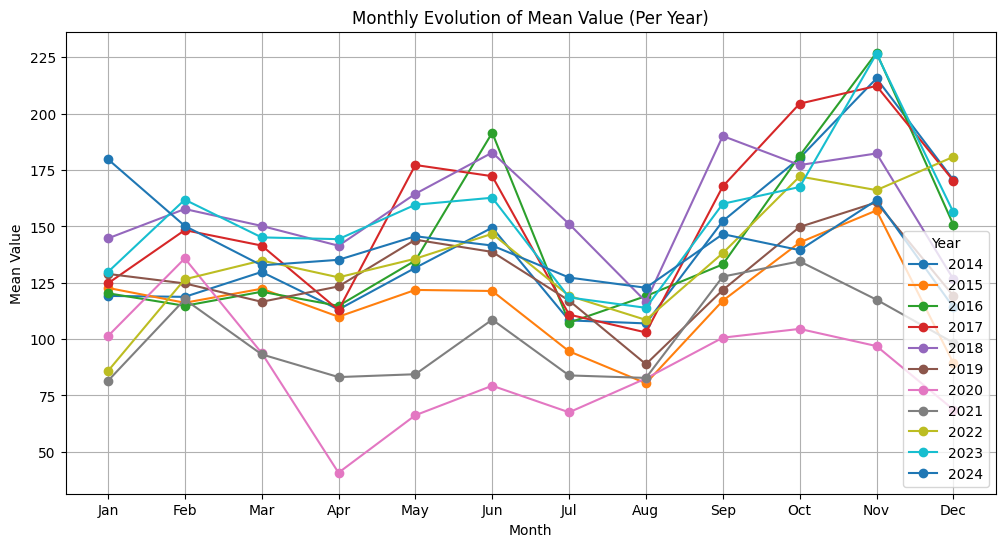

In [ ]:
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)

df["month"] = df["month"].astype(int)
df = df.sort_values(["year", "month"])

plt.figure(figsize=(12, 6))

for year, group in df.groupby("year"):
    plt.plot(group["month"], group["mean_arrival"], marker="o", linestyle="-", label=f"{year}")

plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.xlabel("Month")
plt.ylabel("Mean Delay Arrival")
plt.title("Monthly Evolution of Mean Delay Arrival (Per Year)")
plt.legend(title="Year")
plt.grid(True)

plt.show()

Most years seem to follow a similar evolution of the delay over the months except for 2020 and 2021, most likely due to covid. We can observe that there is a spike in delay in june and also october and november with nomvember having the highest spike over the years, but there is also a decrease in delays in july and august. All the other months have similar delays.

In [13]:
query = """
    SELECT SERVICE.name, COUNT(train_data.train_service) AS Train_service_count
    FROM train_data
    LEFT JOIN SERVICE ON train_data.train_service = SERVICE.id
    GROUP BY SERVICE.name
    ORDER BY Train_service_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()


,name,train_service_count
0,CAPTRAIN,3
1,RAILTRAXX,5
2,CROSSRAIL,50
3,BELGORAIL,97
4,EURSLEEPER,12286
5,EUROSTAR,87583
6,EUROSTARFR,159784
7,THI-FACT,2251383
8,SNCB/NMBS,240602732


Out of the 8 services, 4 of them are used extremely rarely. The SNCB/NMBS service is used for around 90% of the travels and the others are rarer but still used frequently

In [10]:
query = """
SELECT 
TO_CHAR(departure_date, 'MM-DD') AS calendar_day,
AVG((delay_arrival + delay_departure) / 2) AS avg_delay
FROM TRAIN_DATA
GROUP BY calendar_day
ORDER BY avg_delay DESC;"""

df = pd.read_sql(sqla.text(query), connection)



<bound method NDFrame.head of     calendar_day   avg_delay
0          11-23  222.650284
1          11-21  210.767064
2          11-29  209.579583
3          11-02  209.352563
4          10-21  208.002446
..           ...         ...
361        07-21   81.626849
362        12-24   70.578410
363        12-31   70.026775
364        01-01   61.952130
365        12-25   47.447403

[366 rows x 2 columns]>

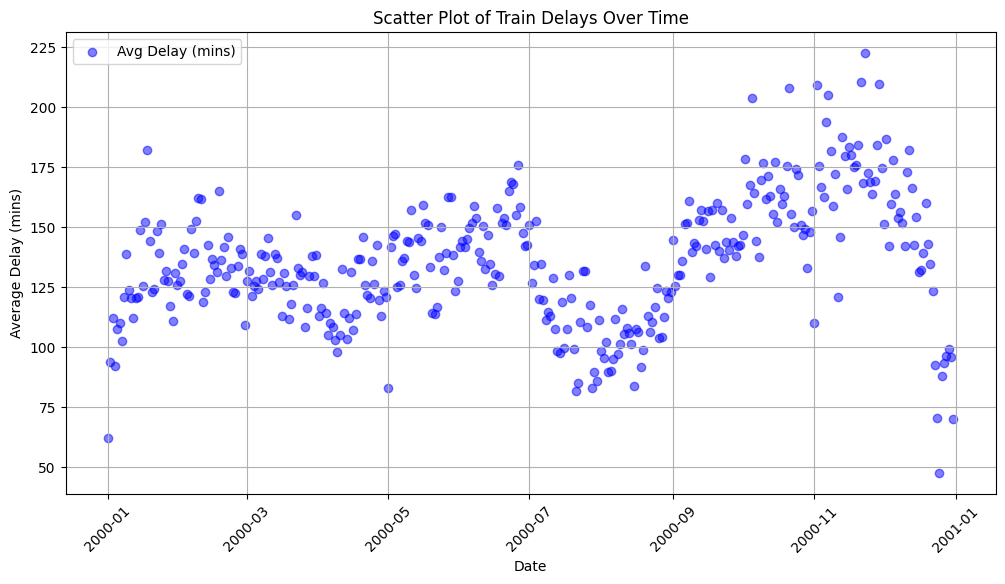

In [ ]:
#Fixed year to be able to convert it to datetime
df["calendar_day"] = "2000-" + df["calendar_day"]
df["calendar_day"] = pd.to_datetime(df["calendar_day"])

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df["calendar_day"], df["avg_delay"], color="blue", alpha=0.5, label="Avg Delay (mins)")

# Formatting
plt.xlabel("Date")
plt.ylabel("Average Delay (mins)")
plt.title("Scatter Plot of Train Delays Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels

# Show plot
plt.show()

This plot is very similar to the one comparing the delay per month, we can observe the same spike in june, october and november and a similar decrease in july and august. The average delay per month was not due to having a few days with higher delays but an overal increase in delay all month long.

In [53]:
query = """
SELECT 
    TO_CHAR(departure_date, 'Day') AS weekday,
    EXTRACT(DOW FROM departure_date) AS weekday_number,
    AVG(delay_arrival) AS avg_arrival_delay,
    AVG(delay_departure) AS avg_departure_delay
FROM train_data
GROUP BY weekday, weekday_number
ORDER BY weekday_number;
"""

df = pd.read_sql(sqla.text(query), connection)

print(df)

     weekday  weekday_number  avg_arrival_delay  avg_departure_delay
0  Sunday                0.0         100.337964           108.013831
1  Monday                1.0         143.720395           148.257006
2  Tuesday               2.0         139.719646           144.336916
3  Wednesday             3.0         133.782585           138.508522
4  Thursday              4.0         138.109238           142.782252
5  Friday                5.0         142.523834           147.261583
6  Saturday              6.0         108.512081           115.779139


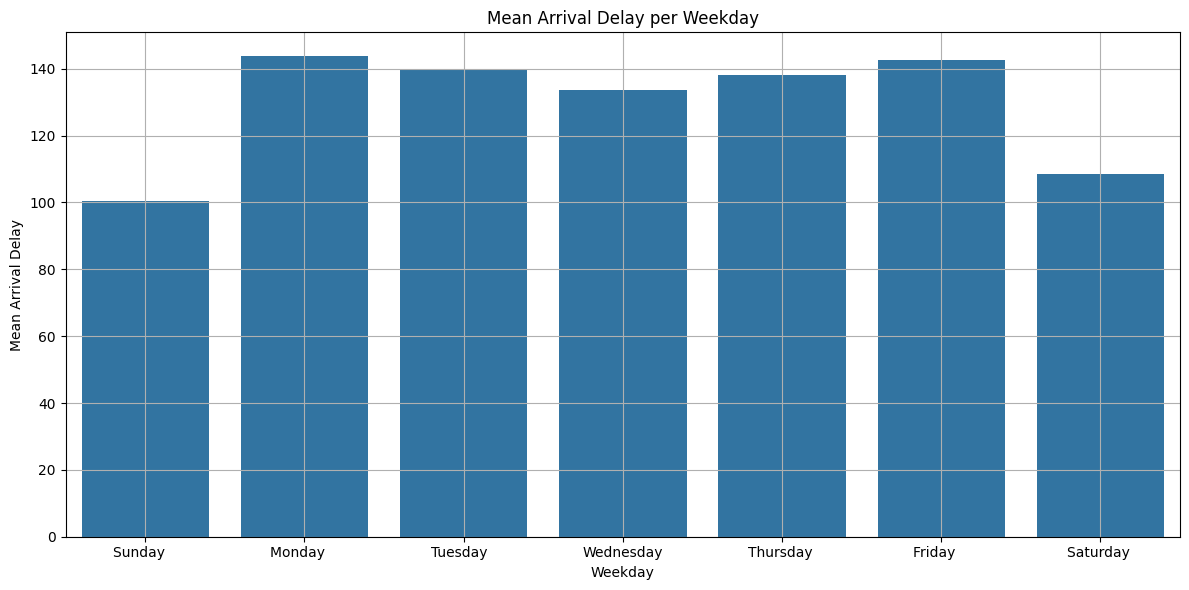

In [11]:
# using sns to plot the data in a bar chart
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.barplot(x="weekday", y="avg_arrival_delay", data=df)
plt.xlabel("Weekday")
plt.ylabel("Mean Arrival Delay")
plt.title("Mean Arrival Delay per Weekday")
plt.grid(True)
plt.tight_layout()
plt.show()


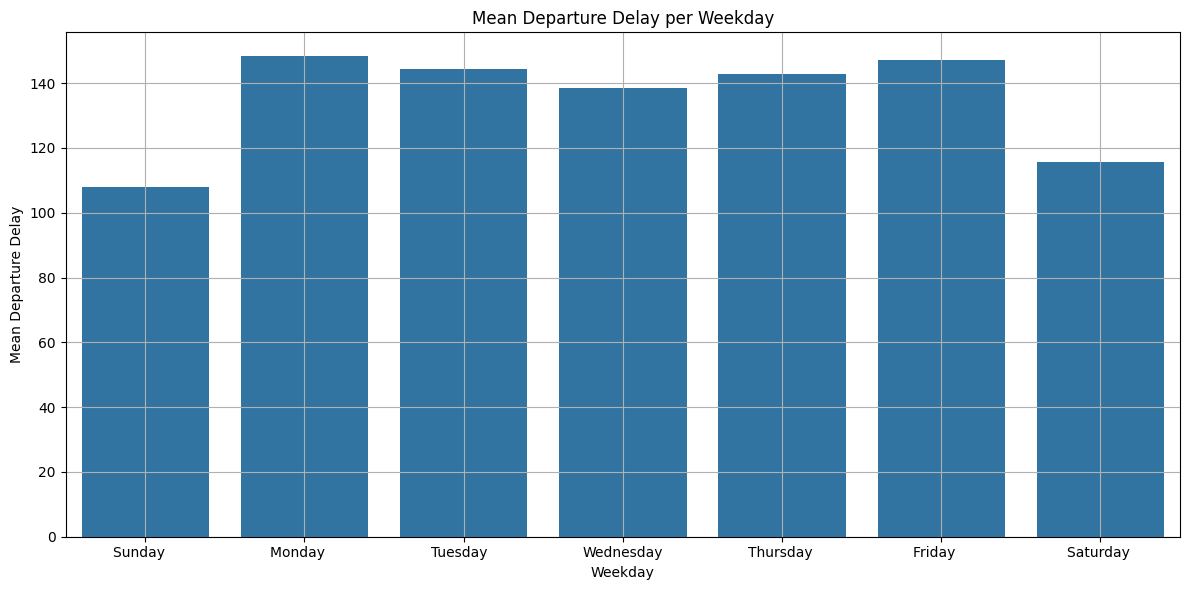

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(x="weekday", y="avg_departure_delay", data=df)
plt.xlabel("Weekday")
plt.ylabel("Mean Departure Delay")
plt.title("Mean Departure Delay per Weekday")
plt.grid(True)
plt.tight_layout()
plt.show()

Looking at the delays depending on the days of the week, we can observe that delays are higher during weekdays than during week-ends.

## INDEX TENTATIVES

In [ ]:
query = """ CREATE INDEX idx_station_check ON train_data (ptcar_name,station_departure, station_arrival);"""

try :
    connection.execute(sqla.text(query))
except Exception as e:
    print(e)

(psycopg2.errors.DuplicateTable) relation "idx_station_check" already exists

[SQL:  CREATE INDEX idx_station_check ON DATANASE (ptcar_name,station_departure, station_arrival);]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
query = """DROP INDEX IF EXISTS idx_station_check;"""
try:
    connection.execute(sqla.text(query))
except Exception as e:
    print(e)
    connection.rollback()

#query = """DROP INDEX idx_null_check ON train_data;"""

#connection.execute(sqla.text(query))


In [ ]:
query = """ 
SELECT * 
FROM train_data
WHERE 
    station_departure = 0 OR  
    station_arrival = 0; 
"""

df = pd.read_sql(sqla.text(query), connection)

In [20]:

print(len(df))

## EDA CONT

In [51]:
query = """
    SELECT * from train_data WHERE train_service = 5;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df["relation"].unique())
except Exception as e:
    print(e)
    connection.rollback()

array([58])

In [14]:
query = """
    SELECT RELATION.name, COUNT(train_data.relation) AS Relation_count
    FROM train_data
    LEFT JOIN RELATION ON train_data.relation = RELATION.id
    GROUP BY RELATION.name
    ORDER BY Relation_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,name,relation_count
0,None,0
1,L A2-2,152
2,S8-P,758
3,THAL 03,1619
4,L L37-2,2080
...,...,...
212,IC 18,4981537
213,IC 01,5772051
214,IC 25,7625935
215,P,12834054


There are 216 different relation in the dataset, the most common are the Intercity trains followed by those in rush hours (P). The least common ones are internationals trains and some local ones. 

In [16]:
query = """
    SELECT STATIONS.name, COUNT(train_data.ptcar_name) AS STATION_count
    FROM train_data
    LEFT JOIN STATIONS ON train_data.ptcar_name = STATIONS.id
    GROUP BY STATIONS.name
    ORDER BY STATION_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,name,station_count
0,FELUY-ZONING,1
1,EIJSDEN,1
2,CLABECQ-MARCHANDISES,1
3,TROISVIERGES,1
4,ROTTERDAM CENTRAAL,1
...,...,...
786,BRUSSEL-CONGRES,3897367
787,BRUSSEL-KAPELLEKERK,3897420
788,BRUSSEL-CENTRAAL,3897471
789,BRUSSEL-NOORD,3915972


There are a few stations that have been rarely used, but the ones seeing the most traffics are all the stations within the capital city. The stations used only one time may have been due to some exceptional circumstances such as accident on the tracks, or may be due to a train that had only one travel

In [21]:
query = """
   SELECT train_data.ptcar_name, STATIONS.name, COUNT(train_data.ptcar_name) AS STATION_count 
FROM train_data
LEFT JOIN STATIONS ON train_data.ptcar_name = STATIONS.id
GROUP BY train_data.ptcar_name, STATIONS.name
HAVING COUNT(train_data.ptcar_name) < 10
ORDER BY STATION_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,ptcar_name,name,station_count
0,188,CLABECQ,1
1,189,CLABECQ-MARCHANDISES,1
2,226,EIJSDEN,1
3,637,ROTTERDAM CENTRAAL,1
4,759,VOROUX-BASE TRAVAUX LGV,1
5,30,ANTWERPEN-D.S.-IJSLAND,1
6,31,ANTWERPEN-D.S.-LILLO,1
7,535,MONCEAU-CHARGEMENT GASOIL,1
8,33,ANTWERPEN-D.S.-PETROL,1
9,34,ANTWERPEN-D.S.-WILMARSDONK,1


We selected only the stations which had less than 10 stops. There are 400 of them and most of them are from Antwerpen.

In [41]:
toCheck = df["ptcar_name"].astype(int).tolist()
print(toCheck)
query = sqla.text("SELECT * FROM train_data WHERE ptcar_name IN :values")
df_result = pd.read_sql(query, connection, params={"values": tuple(toCheck)})

[188, 189, 226, 637, 759, 30, 31, 535, 33, 34, 467, 446, 295, 24, 254, 733, 285, 29, 63, 297, 487, 543, 702, 32, 62, 51, 336, 288, 36, 60, 807, 296, 27, 26, 293, 25, 806, 802, 46, 790]


In [42]:
print(df_result)

    departure_date  train_number  relation  train_service  ptcar_number  \
0       2014-03-03         17906         2              7          1505   
1       2014-01-16         17914         2              7           861   
2       2014-01-16         17916         2              7           861   
3       2014-03-26         17937         2              7          1505   
4       2014-04-24         17907         2              7          1505   
..             ...           ...       ...            ...           ...   
119     2024-10-05           783       165              7          1888   
120     2024-10-05           782       165              7          1888   
121     2024-10-05           784       165              7          1888   
122     2024-11-05         14402         0              7          1722   
123     2024-11-05         14403         0              7          1722   

    line_number_departure real_time_arrival real_time_departure  \
0                   27L/5       

Looking at the full rows for the stations with very few travels, we found out that most of them are from extra services. Other values are from local trains which are already fewer inside the dataset so them having very little stops could be explained by that.

In [55]:
query = """
   WITH Total AS (
    SELECT COUNT(*) AS total_trains FROM TRAIN_DATA
)
SELECT 
    relation, 
    COUNT(delay_arrival) AS count_trains,
    AVG(delay_arrival) AS mean_delay_arrival,
    (COUNT(delay_arrival) * 100.0 / (SELECT total_trains FROM Total)) AS percentage_trains
FROM TRAIN_DATA
GROUP BY relation
ORDER BY mean_delay_arrival DESC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,relation,count_trains,mean_delay_arrival,percentage_trains
0,0.0,32352,627.930483,1.330734e-02
1,212.0,1707797,414.350366,7.024678e-01
2,56.0,864033,371.466828,3.554025e-01
3,1.0,273281,367.744849,1.124086e-01
4,215.0,1613,362.127092,6.634750e-04
...,...,...,...,...
212,176.0,1872,27.180556,7.700094e-04
213,93.0,99788,25.521726,4.104578e-02
214,91.0,22956,24.591697,9.442487e-03
215,26.0,24752,12.083791,1.018124e-02


The relations with higher delays are either the extra travels, or travels towards other countries. The lowest delays are for local and IC travels, which are more frequent and would require lower delays.

In [22]:
query = """
SELECT 
    train_service, 
    COUNT(*) AS service_count,
    AVG(delay_departure) AS avg_delay
FROM TRAIN_DATA
GROUP BY train_service
ORDER BY avg_delay DESC;"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,train_service,service_count,avg_delay
0,2,50,3134.360000
1,5,12286,904.273655
2,8,2251383,383.250478
3,4,159784,357.776465
4,1,3,311.000000
5,3,87583,250.270573
6,7,240602732,135.552364
7,6,5,0.000000
8,0,97,-73.443299


Now comparing delays between the train services, we can see that the services which go outside of the country have on average a higher delay, The SNCB/NMBS has an average delay of a bit over 2 minutes which is fairly low. Also, Belgorail, Railtraxx, Captrain and Crossrail are services that are very rarely used, all of them combined don't even make 1% of the travels within the dataset.

In [58]:
query = """
SELECT 
    (100.0 * SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) / COUNT(*)) AS percentage_greater_than_zero
FROM train_data;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,percentage_greater_than_zero
0,11.9828


Looking at the infos given by the SNCB, they consider a train to be late from 6 minutes, this makes that 11.98% of the trains in the dataset were running late.

In [21]:
connection.rollback()

In [8]:
query = """
SELECT departure_date, 
AVG(delay_arrival) AS avg_delay_per_train
FROM TRAIN_DATA
GROUP BY departure_date
ORDER BY avg_delay_per_train DESC
LIMIT 10; """

df = pd.read_sql(sqla.text(query), connection)

display(df)

,departure_date,avg_delay_per_train
0,2014-12-15,2659.030052
1,2023-11-02,1196.010219
2,2016-10-05,580.378941
3,2024-01-18,542.550820
4,2019-07-25,508.139963
5,2022-02-18,492.996752
6,2017-02-18,470.392169
7,2017-11-23,467.244241
8,2020-02-09,457.280170
9,2016-11-21,455.799526


 Looking at the days with the highest average delay, we found some explanations for some of them : 2014-12-15, strike day, 2023-11-02 : storm, 2016-10-05 bomb alert, 2024-01-18 cyber attack, 2020-02-09 repairs on the tracks

In [17]:
query = """
SELECT 
    ptcar_name, 
    AVG(COALESCE(delay_departure, 0) - COALESCE(delay_arrival, 0)) AS avg_station_delay
FROM TRAIN_DATA
GROUP BY ptcar_name
HAVING COUNT(*) >= 100  -- Ensure the ptcar_name appears at least 100 times
ORDER BY avg_station_delay DESC
LIMIT 20;"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,ptcar_name,avg_station_delay
0,706,738.033109
1,669,172.755772
2,523,156.220404
3,48,109.833663
4,668,106.526316
5,541,84.132450
6,50,82.421111
7,650,81.321839
8,145,73.308458
9,443,66.472071


Having a look at the delay that is accumulated at a current stop, only considering stations appearing at least 100 times to not have high values for a single travel. The highest average delay is really big, a train will on average be late by an additional 12 minutes by going through this station. The others 19 highest average delay on a station are more reasonable, with a maximum of only an additional 3 minutes of delay but most of them having around 1 minute.

In [21]:
q = """
SELECT 
    EXTRACT(MONTH FROM date) AS month,
    AVG(temperature_2m) AS avg_temperature_2m,
    AVG(apparent_temperature) AS avg_apparent_temperature,
    AVG(dewpoint_2m) AS avg_dewpoint_2m,
    AVG(relative_humidity_2m) AS avg_relative_humidity_2m,
    AVG(precipitation) AS avg_precipitation,
    AVG(rain) AS avg_rain,
    AVG(snowfall) AS avg_snowfall,
    AVG(cloudcover) AS avg_cloudcover,
    AVG(cloudcover_low) AS avg_cloudcover_low,
    AVG(cloudcover_mid) AS avg_cloudcover_mid,
    AVG(cloudcover_high) AS avg_cloudcover_high,
    AVG(windgusts_10m) AS avg_windgusts_10m,
    AVG(shortwave_radiation) AS avg_shortwave_radiation,
    AVG(direct_radiation) AS avg_direct_radiation,
    AVG(diffuse_radiation) AS avg_diffuse_radiation,
    AVG(direct_normal_irradiance) AS avg_direct_normal_irradiance,
    AVG(et0_fao_evapotranspiration) AS avg_et0_fao_evapotranspiration
FROM WEATHER
GROUP BY month
ORDER BY month;"""

df = pd.read_sql(sqla.text(q), connection)

display(df)

,month,avg_temperature_2m,avg_apparent_temperature,avg_dewpoint_2m,avg_relative_humidity_2m,avg_precipitation,avg_rain,avg_snowfall,avg_cloudcover,avg_cloudcover_low,avg_cloudcover_mid,avg_cloudcover_high,avg_windgusts_10m,avg_shortwave_radiation,avg_direct_radiation,avg_diffuse_radiation,avg_direct_normal_irradiance,avg_et0_fao_evapotranspiration
0,1.0,3.920275,-0.326075,1.784543,86.478210,0.100749,0.089479,0.007940,76.866691,55.538001,36.285394,40.803804,32.218923,33.715502,14.212488,19.503014,57.477383,0.022084
1,2.0,5.231007,0.928434,2.094578,81.252322,0.100000,0.094520,0.003876,68.826724,45.593426,34.788049,41.519605,34.250612,66.011701,34.680198,31.331502,101.004698,0.039962
2,3.0,7.061791,3.272707,3.058871,77.265192,0.090795,0.087524,0.002309,64.854024,38.176890,34.571766,39.416096,30.222581,117.260753,66.761160,50.499593,146.125872,0.065906
3,4.0,9.793110,6.717134,4.638527,72.332449,0.061402,0.059642,0.001231,60.921212,29.235354,30.997180,35.418182,26.560669,183.669192,109.591414,74.077778,198.102584,0.105233
4,5.0,13.629509,11.570406,8.355543,72.529977,0.088518,0.088425,0.000066,63.359726,27.557225,32.145528,40.248534,25.847495,218.087773,127.347670,90.740103,208.591561,0.135066
5,6.0,17.528598,16.564019,11.838418,71.510985,0.103455,0.103455,0.000000,61.167887,28.253704,29.163215,36.475168,24.913843,235.112668,140.433039,94.679630,222.031995,0.161707
6,7.0,18.836396,18.174466,13.040775,71.378747,0.100550,0.100550,0.000000,61.393491,27.619053,30.390885,35.809669,25.443320,221.363473,132.097630,89.265844,214.785504,0.159461
7,8.0,18.779778,18.245837,13.401112,73.197784,0.092457,0.092457,0.000000,59.752810,24.602843,28.894265,36.507209,24.593996,190.901434,117.184629,73.716805,203.247609,0.139358
8,9.0,15.821465,14.604567,11.466604,77.051052,0.086827,0.086827,0.000000,59.520833,27.895160,26.753241,34.502146,24.057142,141.298737,85.656818,55.641919,172.880703,0.098200
9,10.0,12.346057,10.073892,9.257987,82.270202,0.095850,0.095829,0.000014,72.080564,38.449088,32.846041,43.839198,28.054802,78.618524,41.283847,37.334677,107.752810,0.055613


In [13]:
# Create a new column for month names
df['month'] = df['month'].apply(lambda x: f'Month {x}')

# Set the month as the index for easier plotting
df.set_index('month', inplace=True)


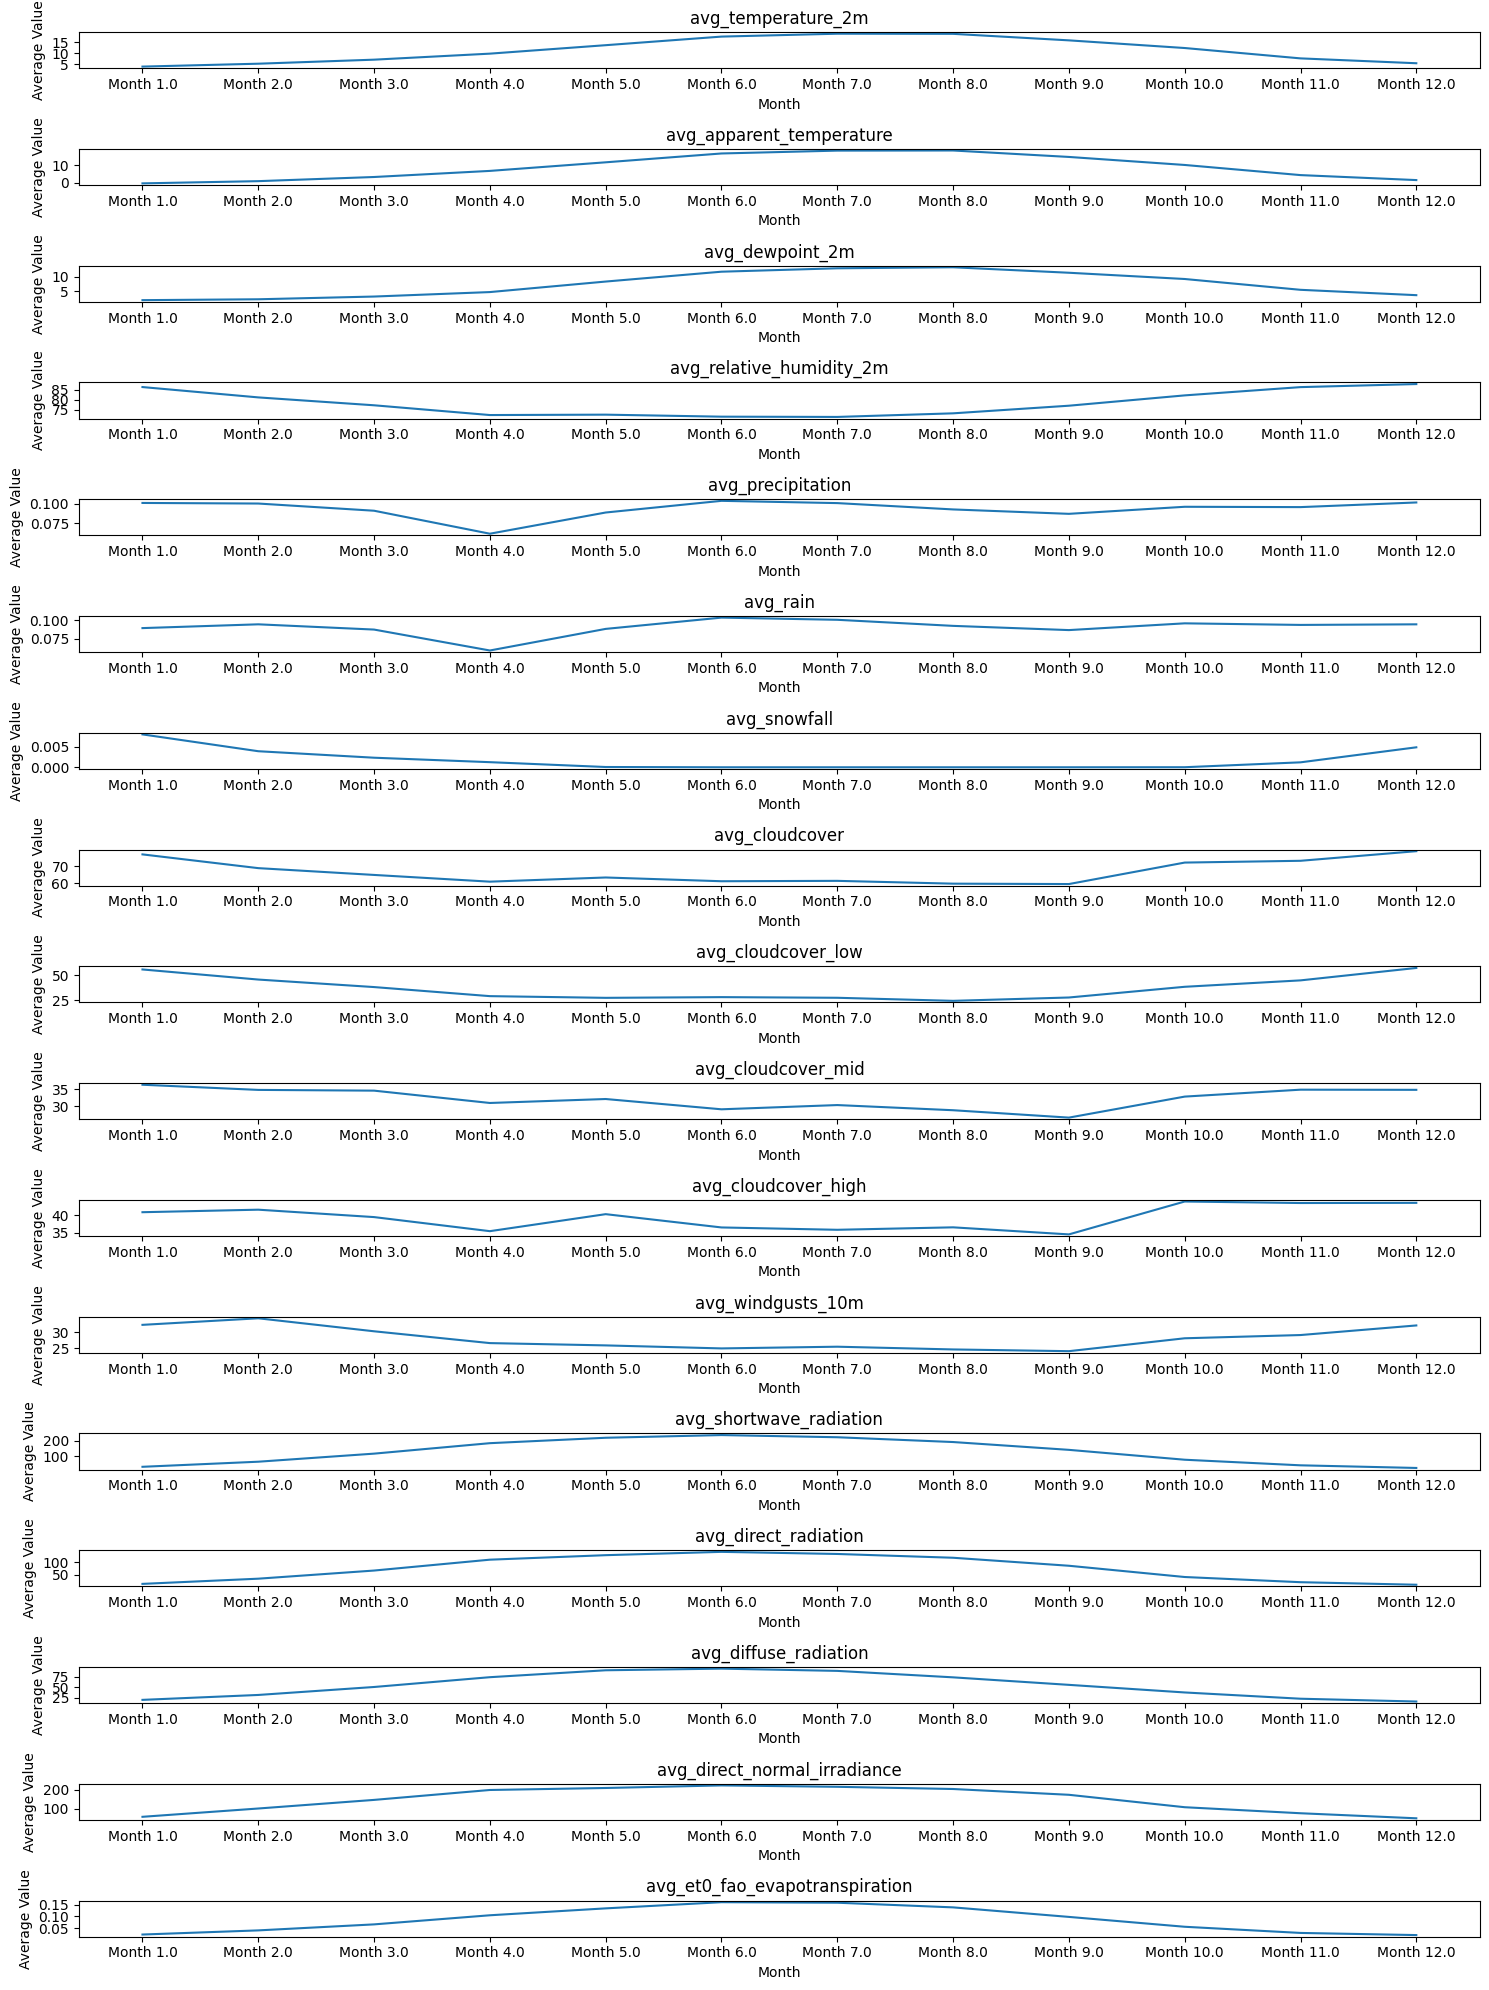

In [15]:
# Plotting
plt.figure(figsize=(15, 20))

# Loop through each column to plot
for i, column in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i + 1)
    plt.plot(df.index, df[column], label=column)
    plt.title(column)
    plt.xlabel('Month')
    plt.ylabel('Average Value')

plt.tight_layout()
plt.show()

In [17]:
query = """
SELECT 
    EXTRACT(MONTH FROM departure_date) AS month,
    AVG(delay_departure) AS avg_train_delay
FROM TRAIN_DATA
GROUP BY month
ORDER BY month;
"""

train = pd.read_sql(sqla.text(query), connection)

display(train)

,month,avg_train_delay
0,1.0,126.974758
1,2.0,138.463517
2,3.0,130.739246
3,4.0,121.655436
4,5.0,139.728102
5,6.0,150.244418
6,7.0,116.889538
7,8.0,109.579014
8,9.0,146.450219
9,10.0,163.226252


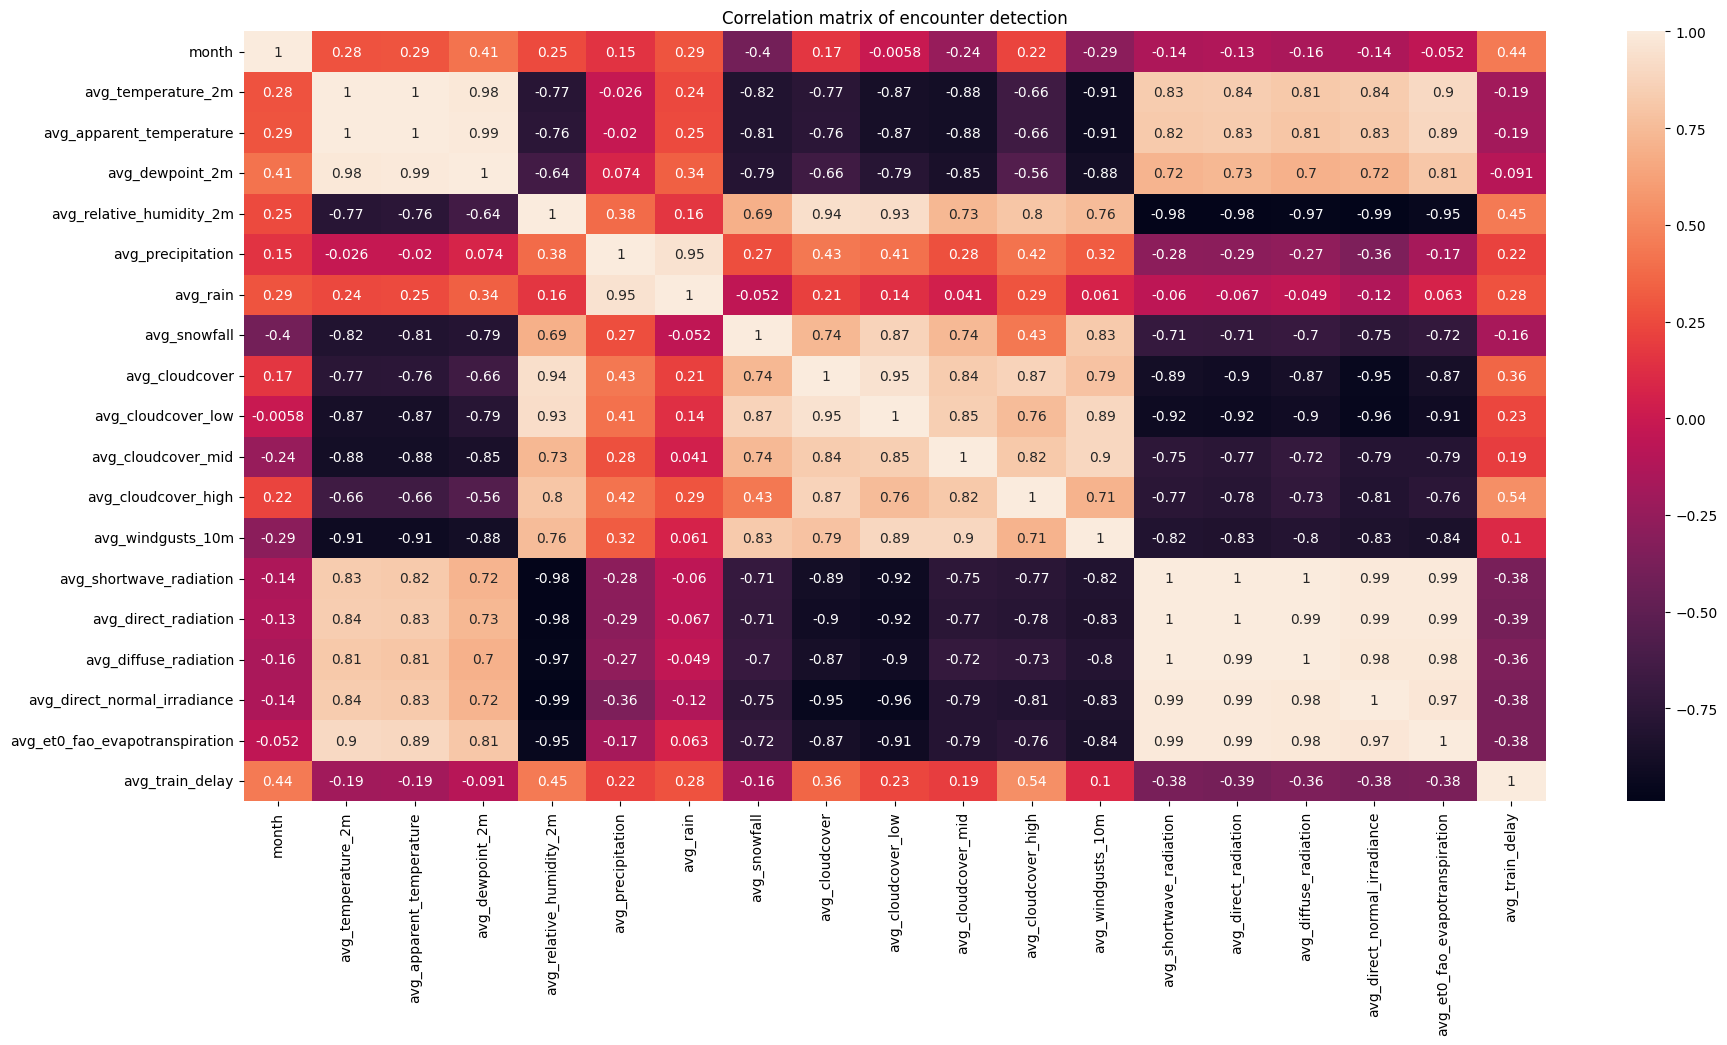

In [22]:
import seaborn as sns
merged = pd.merge(df, train, on='month')
corr = merged.corr()

fig  = plt.figure(figsize=(21, 10))
sns.heatmap(corr, annot=True,)
plt.title('Correlation matrix of encounter detection')
plt.show()

Looking at the correlation between the average delay and the weather a few variables seem interesting, there are higher correlation with relative humidity, high cloud cover and the radiation. We expected that the correlation of the delays with windgust and precipitation would be higher.

In [4]:
query = """
    SELECT 
        td.holiday AS day_type,
        AVG(t.delay_arrival) AS mean_delay_arrival,
        AVG(t.delay_departure) AS mean_delay_departure
    FROM TRAIN_DATA t
    JOIN type_day td ON t.departure_date = td.date
    GROUP BY td.holiday
    ORDER BY td.holiday;
"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,day_type,mean_delay_arrival,mean_delay_departure
0,0,147.978449,151.106529
1,1,112.326090,118.432924
2,2,119.582693,127.540854
3,3,78.549798,87.207314
